# Structural Estimation PS3
Meng Yang 12245345

## 1. Matching the U.S income distribution by GMM

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt 
import numpy.linalg as lin
import scipy.stats as sts
from scipy.stats import lognorm
import scipy.integrate as intgr
import scipy.optimize as opt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 
from scipy.integrate import quad

In [2]:
pts = np.loadtxt('hh_inc_synth.txt')
N = len(pts)
print('max: ',pts.max())
print('min: ',pts.min())
print('mean: ', pts.mean())
print('std: ',pts.std())

max:  349978.7695007046
min:  1.0830783075610473
mean:  67269.598228936
std:  60632.291036072565


### (a) Data moment

In [3]:
bin = []
i = 0
for i in range(41):
    int_edge = i * 5000 
    bin.append(int_edge)
    i += 1
bin.extend([250000, 350000])
bin = np.asarray(bin)

In [4]:
def data_moment(xvals):
    hist, bin_edges = np.histogram(xvals, bins = bin)    
    return hist
hist = data_moment(pts)
print('Data moments: ', hist)

Data moments:  [4261 4972 7127 6882 7095 6591 6667 6136 5795 4945 5170 4250 4432 3836
 3606 3452 3036 2566 2594 2251 2527 1771 1723 1569 1540 1258 1211  918
 1031  893 1166  740  697  610  617  530  460  363  380  312 2297 2808]


### (b) Histogram

Text(0.5, 1.0, 'U.S income distribution')

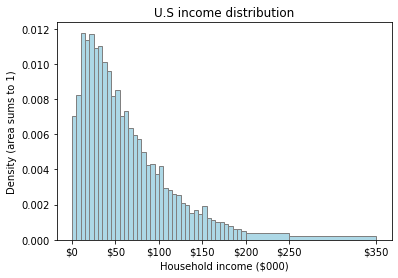

In [5]:
w = [1/(N * 5)] 
weight = w * N

pos_40 = N - hist[41] - hist[40]
pos_41 = N - hist[41]

i = pos_40
for i in range(pos_40, pos_41):
    weight[i] = weight[i] / 10
    i += 1

i = pos_41
for i in range (pos_41 , N):
        weight[i] = weight[i] / 20
        i += 1

bin_adj = [i/1000 for i in bin]
pts_adj = np.sort(pts/1000)

positions = (0, 50, 100, 150, 200, 250, 350)
labels = ('$0','$50', '$100','$150','$200','$250','$350')
plt.xticks(positions, labels)
plt.hist(pts_adj, bins = bin_adj, weights = weight, edgecolor = 'grey', color = 'lightblue')
plt.xlabel(r'Household income ($000)')
plt.ylabel(r'Density (area sums to 1)')
plt.title(r'U.S income distribution')

### (c) Fit with Lognormal 
$$ \text{(LN):}\quad f(x;\mu,\sigma) = \frac{1}{x\sigma\sqrt{2\pi}}e^{-\frac{[\ln(x)-\mu]^2}{2\sigma^2}},\quad x\in(0,\infty), \:\mu\in(-\infty,\infty),\: \sigma>0 $$

R = 42, K = 2

In [6]:
data_m = np.true_divide(hist, N) # use percent as moments

def LN_pdf(xvals, mu, sigma):
    pdf = (np.exp(-(np.log(xvals) - mu)**2 / (2 * sigma**2))/ (xvals * sigma * np.sqrt(2 * np.pi)))
    
    return pdf

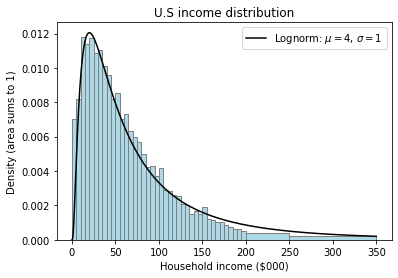

In [7]:
# try to fit data with lognorm distribution with arbitrary paramter values 
plt.hist(pts_adj, bins = bin_adj, weights = weight, edgecolor = 'grey', color = 'lightblue')
plt.xlabel(r'Household income ($000)')
plt.ylabel(r'Density (area sums to 1)')
plt.title(r'U.S income distribution')

dist_pts = np.linspace(1e-10,350, 500)
plt.plot(dist_pts, LN_pdf(dist_pts, 4, 1), color = 'k', label = 'Lognorm: $\mu = 4$, $\sigma = 1$')
plt.legend(loc = 'upper right')

In [8]:
def model_moments_LN(mu, sigma):
    fx = lambda x: LN_pdf(x, mu, sigma)
    model_m = []
    i = 0
    for i in range(42):
        j,err = quad(fx, bin_adj[i], bin_adj[i+1])
        model_m.append(j)
        i += 1 
    
    return model_m    
    
def err_vec_LN(mu, sigma, simple):
    model_m = model_moments_LN(mu, sigma)

    if simple:
         err_vec = model_m - data_m
    else: 
        err_vec = (model_m - data_m)/data_m
            
    return err_vec


def crit_LN(params, *args):
    
    mu, sigma = params
    xvals, W = args
    err = err_vec_LN(mu, sigma, simple = False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [9]:
mu_0 = np.log(pts_adj.mean())
sig_0 = 1
W_0 = np.diag(data_m)
params_0 = np.array([mu_0, sig_0])
gmm_args = (pts_adj, W_0)
print('params_0: ', params_0)
print('W_0: ', W_0)

params_0:  [4.2087084 1.       ]
W_0:  [[0.03519016 0.         0.         ... 0.         0.         0.        ]
 [0.         0.04106206 0.         ... 0.         0.         0.        ]
 [0.         0.         0.05885948 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.0025767  0.         0.        ]
 [0.         0.         0.         ... 0.         0.01897014 0.        ]
 [0.         0.         0.         ... 0.         0.         0.02319032]]


In [10]:
results_GMM_LN = opt.minimize(crit_LN, params_0, args = (gmm_args), 
                              method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_gmm, sigma_gmm = results_GMM_LN.x
crit_gmm_LN = results_GMM_LN.fun
print('mu_gmm_LN: ', mu_gmm)
print('sigma_gmm_LN: ', sigma_gmm)
print('minimized criterion function_LN: ', crit_gmm_LN)
results_GMM_LN

mu_gmm_LN:  3.8934469297485967
sigma_gmm_LN:  0.9757410634189841
minimized criterion function_LN:  0.0355164793935379


      fun: 0.0355164793935379
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.36397576e-06, 8.40993941e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 5
   status: 0
  success: True
        x: array([3.89344693, 0.97574106])

Text(0.5, 0, 'Crit function')

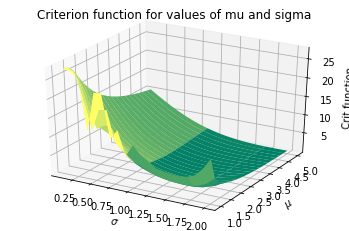

In [11]:
mu_vals = np.linspace(1,5, 20)
sig_vals = np.linspace(0.1,2,20)
crit_vals = np.zeros((20,20))

for mu_i in range(20):
    for sig_i in range(20):
        crit_vals[mu_i, sig_i] = \
        crit_LN(np.array([mu_vals[mu_i],sig_vals[sig_i]]), pts_adj, W_0)
        
mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)

fig = plt.figure()
ax = fig.gca(projection='3d')
cmap1 = matplotlib.cm.get_cmap('summer')
ax.plot_surface(sig_mesh, mu_mesh, crit_vals, rstride = 8, cstride = 1, cmap = cmap1)
ax.set_title('Criterion function for values of mu and sigma')
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\mu$')
ax.set_zlabel(r'Crit function')

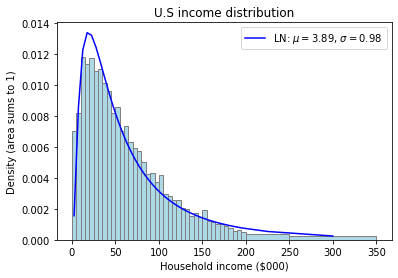

In [12]:
plt.hist(pts_adj, bins = bin_adj, weights = weight, edgecolor = 'grey', color ='lightblue')
plt.xlabel(r'Household income ($000)')
plt.ylabel(r'Density (area sums to 1)')
plt.title(r'U.S income distribution')

dist_pts = []
i = 0
for i in range(42):
    j = (bin_adj[i+1] - bin_adj[i])/2 + bin_adj[i]
    dist_pts.append(j)
    i += 1 

dist_pts = np.asarray(dist_pts)
plt.plot(dist_pts, LN_pdf(dist_pts, mu_gmm, sigma_gmm), color = 'blue',
         label = 'LN: $\mu = 3.89$, $\sigma = 0.98$')
plt.legend(loc = 'upper right')

### (d) Fit GA
$$ \text{(GA):}\quad f(x;\alpha,\beta) = \frac{1}{\beta^\alpha \Gamma(\alpha)}x^{\alpha-1}e^{-\frac{x}{\beta}},\quad x\in[0,\infty), \:\alpha,\beta>0 $$
$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$

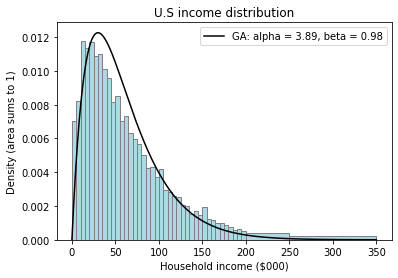

In [13]:
def GA_pdf(xvals, alpha, beta):
    pdf = sts.gamma.pdf(xvals, alpha, loc = 0, scale = beta)
    return pdf

plt.hist(pts_adj, bins = bin_adj, weights = weight, edgecolor = 'grey', color = 'lightblue')
plt.xlabel(r'Household income ($000)')
plt.ylabel(r'Density (area sums to 1)')
plt.title(r'U.S income distribution')

dist_pts = np.linspace(0,350, 500)
plt.plot(dist_pts, GA_pdf(dist_pts, 2, 30), color = 'k', label = 'GA: alpha = 3.89, beta = 0.98')
plt.legend(loc = 'upper right')

In [14]:
def model_moments_GA(alpha, beta):
    fx = lambda x: GA_pdf(x, alpha, beta)
    model_m = []
    i = 0
    for i in range(42):
        j,err = quad(fx, bin_adj[i], bin_adj[i+1])
        model_m.append(j)
        i += 1 
    
    return model_m    
    
def err_vec_GA(alpha, beta, simple):  
    model_m = model_moments_GA(alpha, beta)

    if simple:
         err_vec = model_m - data_m
    else: 
        err_vec = (model_m - data_m)/data_m
            
    return err_vec


def crit_GA(params, *args):
    
    alpha, beta = params
    xvals, W = args
    err = err_vec_GA(alpha, beta, simple = False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [15]:
params_0 = np.array([3, 20])
gmm_args = (pts_adj, W_0)
print('params_0: ', params_0)
print('W_0: ', W_0)

params_0:  [ 3 20]
W_0:  [[0.03519016 0.         0.         ... 0.         0.         0.        ]
 [0.         0.04106206 0.         ... 0.         0.         0.        ]
 [0.         0.         0.05885948 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.0025767  0.         0.        ]
 [0.         0.         0.         ... 0.         0.01897014 0.        ]
 [0.         0.         0.         ... 0.         0.         0.02319032]]


In [16]:
results_GMM_GA = opt.minimize(crit_GA, params_0, args = (gmm_args), 
                              method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_gmm, beta_gmm= results_GMM_GA.x
crit_gmm_GA = results_GMM_GA.fun
print('alpha_gmm_GA: ', alpha_gmm)
print('beta_gmm_GA: ', beta_gmm)
print('minimized criterion function_GA: ', crit_gmm_GA)
results_GMM_GA

alpha_gmm_GA:  1.3670768534441882
beta_gmm_GA:  48.06172812843141
minimized criterion function_GA:  0.014084919188884546


      fun: 0.014084919188884546
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.54744142e-06, -1.06338549e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 48
      nit: 14
   status: 0
  success: True
        x: array([ 1.36707685, 48.06172813])

Text(0.5, 0, 'Crit function')

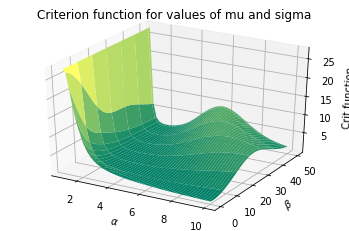

In [19]:
alpha_vals = np.linspace(1,10, 50)
beta_vals = np.linspace(0.1,50,50)
crit_vals = np.zeros((50,50))

for alpha_i in range(50):
    for beta_i in range(50):
        crit_vals[alpha_i, beta_i] = crit_GA(np.array([alpha_vals[alpha_i],beta_vals[beta_i]]), pts_adj, W_0)
        
alpha_mesh, beta_mesh = np.meshgrid(alpha_vals, beta_vals)

fig = plt.figure()
ax = fig.gca(projection='3d')
cmap1 = matplotlib.cm.get_cmap('summer')
ax.plot_surface(alpha_mesh, beta_mesh, crit_vals, rstride = 8, cstride = 1, cmap = cmap1)
ax.set_title('Criterion function for values of mu and sigma')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'Crit function')

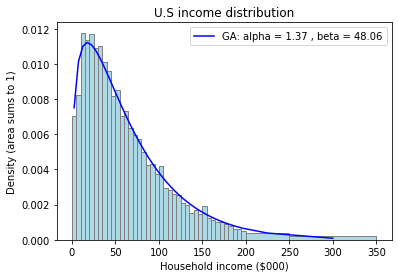

In [21]:
plt.hist(pts_adj, bins = bin_adj, weights = weight, edgecolor = 'grey', color = 'lightblue')
plt.xlabel(r'Household income ($000)')
plt.ylabel(r'Density (area sums to 1)')
plt.title(r'U.S income distribution')

dist_pts = []
i = 0
for i in range(42):
    j = (bin_adj[i+1] - bin_adj[i])/2 + bin_adj[i]
    dist_pts.append(j)
    i += 1 

dist_pts = np.asarray(dist_pts)
plt.plot(dist_pts, GA_pdf(dist_pts, alpha_gmm, beta_gmm), color = 'b',
         label = 'GA: alpha = 1.37 , beta = 48.06')
plt.legend(loc = 'upper right')

### (e) Compare LN and GA

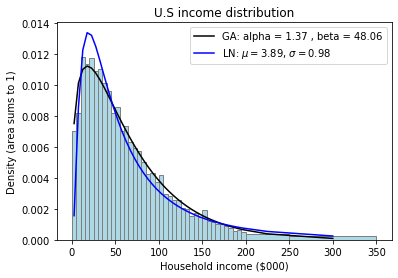

In [22]:
plt.hist(pts_adj, bins = bin_adj, weights = weight, edgecolor = 'grey', color = 'lightblue')
plt.xlabel(r'Household income ($000)')
plt.ylabel(r'Density (area sums to 1)')
plt.title(r'U.S income distribution')

dist_pts = []
i = 0
for i in range(42):
    j = (bin_adj[i+1] - bin_adj[i])/2 + bin_adj[i]
    dist_pts.append(j)
    i += 1 

dist_pts = np.asarray(dist_pts)
plt.plot(dist_pts, GA_pdf(dist_pts, alpha_gmm, beta_gmm), color = 'k',
         label = 'GA: alpha = 1.37 , beta = 48.06')
plt.plot(dist_pts, LN_pdf(dist_pts, mu_gmm, sigma_gmm), color = 'blue',
         label = 'LN: $\mu = 3.89$, $\sigma = 0.98$')
plt.legend(loc = 'upper right')

In [24]:
# compare the criterion function 
print('LN: criterion func value: ', crit_gmm_LN)
print('GA: criterion func value: ', crit_gmm_GA)

# compare the moments error
err_LN = err_vec_LN(mu_gmm, sigma_gmm, simple = False)
err_GA = err_vec_GA(alpha_gmm, beta_gmm, simple = False)
print('err_LN: ', err_LN)
print('err_GA: ', err_GA)

LN: criterion func value:  0.0355164793935379
GA: criterion func value:  0.014084919188884546
err_LN:  [-7.26588718e-01  2.00567178e-02  3.12896990e-02  1.71251611e-01
  1.24625210e-01  1.44237067e-01  4.47134449e-02  3.57613415e-02
 -5.51732321e-03  5.36623292e-02 -8.97886260e-02  1.44573101e-04
 -1.32967522e-01 -9.32335532e-02 -1.25502807e-01 -1.70413288e-01
 -1.41870164e-01 -7.46445900e-02 -1.64215018e-01 -1.19014741e-01
 -2.80908426e-01 -5.81896345e-02 -1.09947050e-01 -9.98773415e-02
 -1.54119200e-01 -4.34373140e-02 -8.07143231e-02  1.23483709e-01
 -7.19777595e-02 -4.72028595e-03 -2.91027220e-01  4.03047642e-02
  2.97646292e-02  9.82872517e-02  1.46478662e-02  1.04950812e-01
  1.92140533e-01  4.16050002e-01  2.69173395e-01  4.51694773e-01
  4.41894618e-01  1.02579461e-01]
err_GA:  [-0.00210419  0.22458084 -0.06784438 -0.01455065 -0.05484033 -0.01271786
 -0.06461304 -0.0345677  -0.03536153  0.06128277 -0.05091842  0.07583268
 -0.0413498   0.02678979  0.01054486 -0.0250773   0.022192

compare the variance-covariance matrix $\hat{\Sigma}_{GMM}$

In [25]:
# LN
def Jac_err_LN(xvals, mu, sigma, simple=False):
    
    Jac_err = np.zeros((42, 2)) # 42 moments and two parameters
   
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    
    Jac_err[:, 0] = \
        ((err_vec_LN(mu + h_mu, sigma, simple) -
          err_vec_LN(mu - h_mu, sigma, simple)) / (2 * h_mu)).flatten()
    
    Jac_err[:, 1] = \
        ((err_vec_LN(mu, sigma + h_sig, simple) -
          err_vec_LN(mu, sigma - h_sig, simple)) / (2 * h_sig)).flatten()
    
    return Jac_err

N = pts_adj.shape[0]
d_err_LN = Jac_err_LN(pts_adj, mu_gmm, sigma_gmm, False)
SigHat2_LN = (1 / N) * lin.inv(d_err_LN.T @ W_0 @ d_err_LN)

print(SigHat2_LN)
print('Std. err. mu_hat=', np.sqrt(SigHat2_LN[0, 0]))
print('Std. err. sig_hat=', np.sqrt(SigHat2_LN[1, 1]))

[[8.98434131e-06 6.42578252e-07]
 [6.42578252e-07 7.07955036e-06]]
Std. err. mu_hat= 0.002997389082021355
Std. err. sig_hat= 0.0026607424455536684


In [26]:
# GA
def Jac_err_GA(xvals, alpha, beta, simple=False):
    
    Jac_err = np.zeros((42, 2)) # 42 moments and two parameters
   
    h_alpha = 1e-8 * alpha
    h_beta = 1e-8 * beta
    
    Jac_err[:, 0] = \
        ((err_vec_GA(alpha + h_alpha, beta, simple) -
          err_vec_GA(alpha - h_alpha, beta, simple)) / (2 * h_alpha)).flatten()
    
    Jac_err[:, 1] = \
        ((err_vec_GA(alpha, beta + h_beta, simple) -
          err_vec_GA(alpha, beta - h_beta, simple)) / (2 * h_beta)).flatten()
    
    return Jac_err

N = pts_adj.shape[0]
d_err_GA = Jac_err_GA(pts_adj, alpha_gmm, beta_gmm, False)
SigHat2_GA = (1 / N) * lin.inv(d_err_GA.T @ W_0 @ d_err_GA)

print(SigHat2_GA)
print('Std. err. alpha_hat=', np.sqrt(SigHat2_GA[0, 0]))
print('Std. err. beta_hat=', np.sqrt(SigHat2_GA[1, 1]))

[[ 2.92322980e-05 -1.12096585e-03]
 [-1.12096585e-03  5.86344109e-02]]
Std. err. alpha_hat= 0.005406690111245057
Std. err. beta_hat= 0.24214543341932374


The value of criterion function value is smaller when fit with Gamma distribution, but the standard deviation of the estimates are smaller in lognormal distribution. From the figure we can see that fitted lognorm distribution mainly capture the mode (low income observations) while Gamma distibution fits the observations in the middle part better.

### (f) Two step GA

In [27]:
# compute the error matrix
def get_err_mat(xvals, alpha, beta, simple = False):
    
    R = 42
    N = len(pts_adj)
    err_mat = np.zeros((R,N))
    model_m = model_moments_GA(alpha, beta)
    
    pts_in_grp0 = pts_adj < 50
    err_mat[0 : ] = (pts_in_grp0 - model_m[0]) / model_m[0]
    
    i = 1 
    for i in range(42):
        pts_in_grp = (pts_adj > bin_adj[i]) & (pts_adj < bin_adj[i+1])
        err_mat[i:] = pts_in_grp- model_m[1] / model_m[i]
        i += 1
    
    return err_mat

In [28]:
err_mat = get_err_mat(pts_adj, alpha_gmm, beta_gmm, False)
VCV = (1 / N) * (err_mat @ err_mat.T)
W_opt = lin.inv(VCV)
print(W_opt)
print(W_0)

[[ 38.69638225  10.36873347  10.4167865  ... -22.58425214   9.77025053
    9.35996466]
 [ 10.36873347  34.81150186  10.50617597 ... -22.49486267   9.85964
    9.44935413]
 [ 10.4167865   10.50617597  27.54384596 ... -22.44680963   9.90769304
    9.49740717]
 ...
 [-22.58425214 -22.49486267 -22.44680963 ... 332.64510041 -23.0933456
  -23.50363148]
 [  9.77025053   9.85964      9.90769304 ... -23.0933456   61.97556717
    8.8508712 ]
 [  9.35996466   9.44935413   9.49740717 ... -23.50363148   8.8508712
   51.56202407]]
[[0.03519016 0.         0.         ... 0.         0.         0.        ]
 [0.         0.04106206 0.         ... 0.         0.         0.        ]
 [0.         0.         0.05885948 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.0025767  0.         0.        ]
 [0.         0.         0.         ... 0.         0.01897014 0.        ]
 [0.         0.         0.         ... 0.         0.         0.02319032]]


In [29]:
params_0_2 = np.array([alpha_gmm, beta_gmm])
gmm_args_2 = (pts_adj, W_opt)
results_GMM_GA_2step = opt.minimize(crit_GA, params_0_2, args = (gmm_args_2), 
                              method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_gmm_2step, beta_gmm_2step= results_GMM_GA_2step.x
crit_gmm_GA_2step = results_GMM_GA_2step.fun
print('alpha_gmm_GA: ', alpha_gmm_2step)
print('sigma_gmm_GA: ', beta_gmm_2step)
print('minimized criterion function_GA: ', crit_gmm_GA_2step)
results_GMM_GA_2step

alpha_gmm_GA:  1.420587402168499
sigma_gmm_GA:  43.73981396840987
minimized criterion function_GA:  52.09754179804158


      fun: 52.09754179804158
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.88702437e-05, -3.55271368e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 13
   status: 0
  success: True
        x: array([ 1.4205874 , 43.73981397])

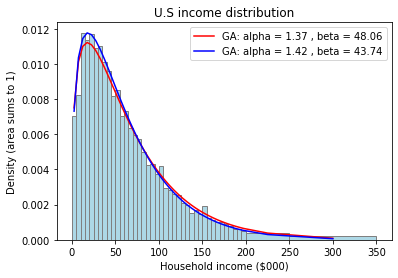

In [31]:
plt.hist(pts_adj, bins = bin_adj, weights = weight, edgecolor = 'grey',color = 'lightblue')
plt.xlabel(r'Household income ($000)')
plt.ylabel(r'Density (area sums to 1)')
plt.title(r'U.S income distribution')

dist_pts = []
i = 0
for i in range(42):
    j = (bin_adj[i+1] - bin_adj[i])/2 + bin_adj[i]
    dist_pts.append(j)
    i += 1 

dist_pts = np.asarray(dist_pts)
plt.plot(dist_pts, GA_pdf(dist_pts, alpha_gmm, beta_gmm), color = 'r',
         label = 'GA: alpha = 1.37 , beta = 48.06')
plt.legend(loc = 'upper right')
plt.plot(dist_pts, GA_pdf(dist_pts, alpha_gmm_2step, beta_gmm_2step), color = 'blue',
         label = 'GA: alpha = 1.42 , beta = 43.74')
plt.legend(loc = 'upper right')

Since the minimized criterion function for 2-step is higher than that with identity matrix, so the estimators are worse than the one-step method.

## Q2  Estimate Brock and Mirman model by GMM

In [32]:
data = np.loadtxt('MacroSeries.txt', delimiter = ',')
c_t, k_t, w_t, r_t = np.loadtxt('MacroSeries.txt', unpack = 'True', delimiter = ',')
df = pd.DataFrame(data, columns = ['c_t', 'k_t', 'w_t', 'r_t'])
df.head()

,c_t,k_t,w_t,r_t
0,1.067109e+07,8.040697e+06,1.059438e+07,0.954120
1,1.169487e+07,7.595072e+06,1.161079e+07,1.107009
2,9.292394e+06,8.323735e+06,9.225588e+06,0.802596
3,7.913165e+06,6.613792e+06,7.856274e+06,0.860176
4,8.140994e+06,5.632136e+06,8.082466e+06,1.039183


### (a) Estimate $\alpha, \rho, \mu$ with unconditional moments
With data $(c_t, k_t, w_t, r_t)$, sequence of $z_t$ can be calculated based on (4)

$$r_t-\alpha e^{z_t} (k_t)^{\alpha-1}=0$$

$$z_t = log(r_t)-(\alpha-1)log(k_t)-log(\alpha)$$

In [33]:
def z(r_t, k_t, alpha):
    z_t = np.log(r_t) - (alpha-1) * np.log(k_t) - np.log(alpha)
    return z_t

Four moment conditions 
$$E[z_{t+1}-\rho z_t - (1-\rho)\mu]=0$$

$$E[(z_{t+1}-\rho z_t - (1-\rho)\mu)z_t]=0$$

$$E[\beta \alpha e^{z_{t+1}}k_{t+1}^{\alpha-1}\frac{c_t}{c_{t+1}}-1]=0$$

$$E[(\beta \alpha e^{z_{t+1}}k_{t+1}^{\alpha-1}\frac{c_t}{c_{t+1}}-1)w_t]=0$$

In [34]:
def data_moments(c_t, k_t, w_t, r_t, alpha, rho, mu):
    z_t = z(r_t, k_t, alpha)
    
    z_lead = z_t[1:] 
    k_lead = k_t[1:]
    c_lead = c_t[1:]
    
    c_t = c_t[:-1]
    k_t = k_t[:-1]
    w_t = w_t[:-1]
    r_t = r_t[:-1]
    z_t = z_t[:-1]

    m1 = z_lead - rho * z_t - (1-rho) * mu
    m2 = (z_lead - rho * z_t - (1-rho) * mu) * z_t
    m3 = 0.99 * alpha * np.exp(z_lead) * k_lead ** (alpha - 1) * c_t / c_lead -1
    m4 = (0.99 * alpha * np.exp(z_lead) * k_lead ** (alpha - 1) * c_t / c_lead -1) * w_t
    
    m1 = m1.mean()
    m2 = m2.mean()
    m3 = m3.mean()
    m4 = m4.mean()
    
    return m1, m2, m3, m4

model_mom = np.array([0, 0, 0, 0])

In [35]:
def err_vec(c_t, k_t, w_t, r_t, alpha, rho, mu, simple):
    
    m1, m2, m3, m4 = data_moments(c_t, k_t, w_t, r_t, alpha, rho, mu)
    data_mom = np.array([m1, m2, m3, m4])
    
    if simple:
        err_vec = model_mom - data_mom
    else:
        err_vec = (model_mom - data_mom) / data_mom
        
    return err_vec

def crit(params, *args):
    
    alpha, rho, mu = params
    c_t, k_t, w_t, r_t, W = args 
    
    err = err_vec(c_t, k_t, w_t, r_t, alpha, rho, mu, simple = True) #since moments are close to zero 
    crit_val = err.T @ W @ err
    
    return crit_val

In [36]:
alpha_0 = k_t/(w_t + k_t) # capital share of output 
alpha_0 = alpha_0.mean()
rho_0 = 0.8 # assume high autocorrelation of TFP
mu_0 = 5
params_0 = np.array([alpha_0, rho_0, mu_0])
W_0 = np.eye(4)
gmm_arg = (c_t, k_t, w_t, r_t, W_0)
bnds = ((1e-10, 1-1e-10), (-1+1e-10, 1-1e-10), (1e-10, None))

results_GMM = opt.minimize(crit, params_0, args = (gmm_arg), bounds = bnds, method = 'L-BFGS-B')
results_GMM

      fun: 1.916620389844048e-08
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.04718248e-05,  5.10959534e-07, -8.57837620e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 32
      nit: 7
   status: 0
  success: True
        x: array([0.46816379, 0.78817327, 9.18135946])

In [37]:
alpha_GMM, rho_GMM, mu_GMM = results_GMM.x
crit_fun = results_GMM.fun
data_m = data_moments(c_t, k_t, w_t, r_t, alpha_GMM, rho_GMM, mu_GMM)
err_vec_estimated = err_vec(c_t, k_t, w_t, r_t, alpha_GMM, rho_GMM, mu_GMM, simple = True)
print('alpha_gmm: ', alpha_GMM)
print('rho_gmm: ', rho_GMM)
print('mu_gmm: ', mu_GMM)
print('minimized criterion function: ', crit_fun)
print('Model moments: ', data_m)
print('moment error: ', err_vec_estimated)

alpha_gmm:  0.4681637943796507
rho_gmm:  0.7881732669300365
mu_gmm:  9.18135946009693
minimized criterion function:  1.916620389844048e-08
Model moments:  (0.00013763040188338374, -1.4969180808228577e-05, 1.390582374277974e-16, 1.3376555230364274e-09)
moment error:  [-1.37630402e-04  1.49691808e-05 -1.39058237e-16 -1.33765552e-09]


Text(0, 0.5, 'estimated value of mu')

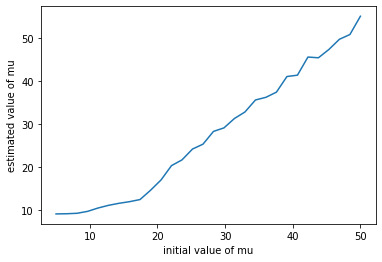

In [38]:
mu_init = np.linspace(5,50,30)
mu_converge = []

i = 0
for i in range(len(mu_init)):
    mu_0 = mu_init[i]
    params_0 = np.array([alpha_0, rho_0, mu_0])
    results_GMM = opt.minimize(crit, params_0, args = (gmm_arg), bounds = bnds, method = 'L-BFGS-B')
    alpha, rho, mu_cov = results_GMM.x
    mu_converge.append(mu_cov)
    
plt.plot(mu_init, mu_converge)
plt.xlabel('initial value of mu')
plt.ylabel('estimated value of mu') 

Estimated value of mu is positively related to the initial guess value of mu and shows no sign of convergence

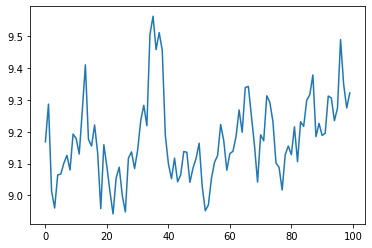

In [39]:
z_t = z(r_t, k_t, alpha_GMM) 
plt.plot(z_t)

### （b) Two-step GMM

In [40]:
def get_err_mat(c_t, k_t, w_t, r_t, alpha, rho, mu, simple = True):
    
    R = 4
    N = len(c_t)
    err_mat = np.zeros((R,N))
    m1, m2, m3, m4 = data_moments(c_t, k_t, w_t, r_t, alpha_GMM, rho_GMM, mu_GMM)
    err_mat[0,:] = m1 - 0
    err_mat[1,:] = m2 - 0
    err_mat[2,:] = m3 - 0
    err_mat[3,:] = m4 - 0
    
    return err_mat

In [41]:
err_mat = get_err_mat(c_t, k_t, w_t, r_t, alpha_GMM, rho_GMM, mu_GMM, simple = True)
VCV2 = (1/c_t.shape[0]) * (err_mat @ err_mat.T)
W_2step = lin.inv(VCV2)
print(W_2step)

[[-3.66401117e+22 -6.92020545e+22 -8.90706828e+33  3.92141052e+27]
 [-5.51458336e+22 -3.27556183e+24 -2.32698191e+35 -6.79108606e+27]
 [-8.12714317e+33 -2.34642161e+35  7.80902216e+44 -1.87077301e+39]
 [ 3.99762978e+27 -5.14276299e+27 -1.76877286e+39 -2.84988099e+32]]


In [42]:
params_init = np.array([alpha_GMM, rho_GMM, mu_GMM])
print('params_init: ', params_init)
gmm_arg_init = (c_t, k_t, w_t, r_t, W_2step)
results_GMM_2step = opt.minimize(crit, params_init, args = (gmm_arg), bounds = bnds, method = 'L-BFGS-B')
results_GMM_2step

params_init:  [0.46816379 0.78817327 9.18135946]


      fun: 1.9166203899211073e-08
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.04718248e-05,  5.10959534e-07, -8.57837620e-08])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 84
      nit: 0
   status: 2
  success: False
        x: array([0.46816379, 0.78817327, 9.18135946])

In [43]:
alpha_GMM_2step, rho_GMM_2step, mu_GMM_2step = results_GMM_2step.x
crit_fun_2step = results_GMM_2step.fun
data_m_2step = data_moments(c_t, k_t, w_t, r_t, alpha_GMM_2step, rho_GMM_2step, mu_GMM_2step)
err_vec_estimated_2step = err_vec(c_t, k_t, w_t, r_t, alpha_GMM_2step, rho_GMM_2step, mu_GMM_2step, simple = True)
print('alpha_gmm_2step: ', alpha_GMM_2step)
print('rho_gmm_2step: ', rho_GMM_2step)
print('mu_gmm_2step: ', mu_GMM_2step)
print('minimized criterion function_2step: ', crit_fun_2step)
print('Model moments_2step: ', data_m_2step)
print('moment error_2step: ', err_vec_estimated_2step)

alpha_gmm_2step:  0.4681637943796507
rho_gmm_2step:  0.7881732669300365
mu_gmm_2step:  9.18135946009693
minimized criterion function_2step:  1.9166203899211073e-08
Model moments_2step:  (0.00013763040188338374, -1.4969180808228577e-05, 1.390582374277974e-16, 1.3376555230364274e-09)
moment error_2step:  [-1.37630402e-04  1.49691808e-05 -1.39058237e-16 -1.33765552e-09]


variance-covariance matrix of the parameters $\hat{\Sigma}_{GMM}$

In [44]:
def Jac_err_macro(c_t, k_t, w_t, r_t, alpha, rho, mu, simple = True):
        
    Jac_err = np.zeros((4, 3)) # 42 moments and two parameters
   
    h_alpha = 1e-8 * alpha
    h_rho = 1e-8 * rho
    h_mu = 1e-8 * mu
    
    Jac_err[:, 0] = \
        ((err_vec(c_t, k_t, w_t, r_t, alpha + h_alpha, rho, mu, simple) -
          err_vec(c_t, k_t, w_t, r_t, alpha - h_alpha, rho, mu, simple)) / (2 * h_alpha)).flatten()
    
    Jac_err[:, 1] = \
        ((err_vec(c_t, k_t, w_t, r_t, alpha, rho + h_rho, mu, simple) -
          err_vec(c_t, k_t, w_t, r_t, alpha, rho - h_rho, mu, simple)) / (2 * h_rho)).flatten()
    
    Jac_err[:, 2] = \
        ((err_vec(c_t, k_t, w_t, r_t, alpha, rho, mu + h_mu, simple) -
          err_vec(c_t, k_t, w_t, r_t, alpha, rho, mu - h_mu, simple)) / (2 * h_mu)).flatten()
    
    return Jac_err

N = pts_adj.shape[0]
d_err = Jac_err_macro(c_t, k_t, w_t, r_t, alpha_GMM_2step, rho_GMM_2step, mu_GMM_2step, simple = True)
SigHat2 = (1 / N) * lin.inv(d_err.T @ W_0 @ d_err)

print(SigHat2)
print('Std. err. alpha_hat=', np.sqrt(SigHat2[0, 0]))
print('Std. err. rho_hat=', np.sqrt(SigHat2[1, 1]))
print('Std. err. mu_hat=', np.sqrt(SigHat2[1, 1]))

[[ 1.32087039e-05 -9.75321905e-06 -2.37350618e-04]
 [-9.75321905e-06  2.45242416e+00  5.61842386e-02]
 [-2.37350618e-04  5.61842386e-02  5.54632425e-03]]
Std. err. alpha_hat= 0.0036343780567458118
Std. err. rho_hat= 1.5660217619595693
Std. err. mu_hat= 1.5660217619595693
